In [ ]:
#default_exp vision.augment
#default_cls_lvl 3

# Data augmentation in computer vision

> Transforms to apply data augmentation in Computer Vision

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc

In [ ]:
# export
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli

In [ ]:
#hide
torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))

In [ ]:
img = Imagify()(Path('images')/'puppy.jpg').resize((600,400))

## RandTransform-

In [ ]:
# export
@docs
class RandTransform(Transform):
    "A transform that randomize its state at each `__call__`, only applied on the training set"
    filt=0
    def __init__(self, encodes=None, decodes=None, randomize=None, p=1.): 
        self.p = p
        if randomize is not None: self.randomize=randomize
        super().__init__(encodes, decodes)
    
    def randomize(self, b): self.do = random.random() < self.p
    
    def __call__(self, b, filt=None, **kwargs): 
        self.randomize(b) #Randomize before calling
        if not getattr(self, 'do', True): return b
        return super().__call__(b, filt=filt, **kwargs)
    
    _docs = dict(randomize="Randomize the state for input `b`")

In [ ]:
show_doc(RandTransform, title_level=2)

<h2 id="<code>class</code> <code>RandTransform</code>" class="doc_header"><code>class</code> <code>RandTransform</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/08_vision_augment.ipynb#RandTransform-" class="source_link" style="float:right">[source]</a></h2>

> <code>RandTransform</code>(**`encodes`**=*`None`*, **`decodes`**=*`None`*, **`randomize`**=*`None`*, **`p`**=*`1.0`*) :: [`Transform`](/data.pipeline.html#Transform)

A transform that randomize its state at each `__call__`, only applied on the training set

As for all `Transform` you can pass `encodes` and `decodes` at init or subclass and implement them. You can do the same for the `randomize` method that is called at each `__call__`. Note that to have a consistent state for inputs and targets, a `RandTransform` must be applied at the tuple level. 

By default the randomize behavior is to execute the transform with probability `p` (if subclassing and wanting to tweak that behavior, the attribute `self.do`, if it exists, is looked for to decide if the transform is executed or not).

> Note: A `RandTransform` is only applied to the training set by default, so you have to pass `filt=0` if you are calling it directly and not through a `Datasource`. That behavior can be changed by setting the class variable `filt` of the transform to `None`.

In [ ]:
show_doc(RandTransform.randomize)

<h4 id="<code>RandTransform.randomize</code>" class="doc_header"><code>RandTransform.randomize</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/08_vision_augment.ipynb#RandTransform-" class="source_link" style="float:right">[source]</a></h4>

> <code>RandTransform.randomize</code>(**`b`**)

Randomize the state for input `b`

In [ ]:
def _add1(x): return x+1
dumb_tfm = RandTransform(_add1, p=0.5)
start = 2
for _ in range(10):
    t = dumb_tfm(start, filt=0)
    if dumb_tfm.do: test_eq(t, start+1)
    else:           test_eq(t, start)

In [ ]:
#hide
def _pnt2tensor(pnts, sz):
    t = torch.zeros(*sz)
    for p in pnts: t[p[1],p[0]] = 1.
    return t

def _tensor2pil(t):
    return Image.fromarray(t.numpy())

### PIL transforms

PIL tranforms need to run before `ImageToByteTensor` (that has an order of 10).

In [ ]:
# export
def _minus_axis(x, axis):
    x[...,axis] = -x[...,axis]
    return x

class PILFlip(RandTransform):
    "Randomly flip with probability `p`"
    def __init__(self, p=0.5): self.p = p
    def encodes(self, x:PILImage):    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    def encodes(self, x:TensorPoint): return _minus_axis(x, 0)
    def encodes(self, x:TensorBBox):
        bb,lbl = x
        bb = _minus_axis(bb.view(-1,2), 0)
        return (bb.view(-1,4),lbl)

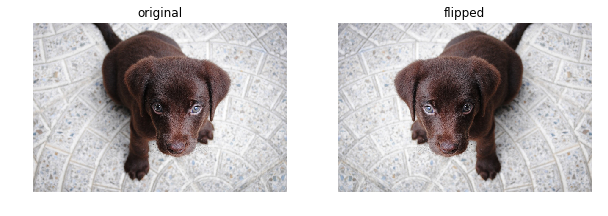

In [ ]:
flip = PILFlip(p=1.)
flip.accept_types(PILImage)
_,axs = plt.subplots(1,2, figsize=(10,4))
show_image(img, ctx=axs[0], title='original')
show_image(flip(img, filt=0), ctx=axs[1], title='flipped');

In [ ]:
flip.accept_types(PILImage)
t = _pnt2tensor([[1,0], [2,1]], (3,3))
x = _tensor2pil(t)
y = flip(x, filt=0)
test_eq(tensor(array(y)), _pnt2tensor([[1,0], [0,1]], (3,3)))

flip.accept_types(TensorPoint)
pnts = tensor([[1.,0], [2,1]]) -1
test_eq(flip(pnts, filt=0), tensor([[1.,0], [0,1]]) -1)


flip.accept_types(TensorBBox)
pnts = tensor([[1.,0., 2.,1]]) -1
test_eq(flip((pnts, ["nothing"]), filt=0)[0], tensor([[1.,0., 0.,1]]) -1)

In [ ]:
# export
class PILDihedral(RandTransform):
    "Applies any of the eight dihedral transformations with probability `p`"
    def __init__(self, p=0.5, draw=None): self.p,self.draw = p,draw
    def randomize(self, b):
        super().randomize(b)
        if self.draw is None: self.idx = random.randint(0,7) 
        else: self.idx = self.draw() if isinstance(self.draw, Callable) else self.draw
        
    def encodes(self, x:PILImage): return x if self.idx==0 else x.transpose(self.idx-1)
    def encodes(self, x:TensorPoint):
        if self.idx in [1, 3, 4, 7]: x = _minus_axis(x, 0)
        if self.idx in [2, 4, 5, 7]: x = _minus_axis(x, 1)
        if self.idx in [3, 5, 6, 7]: x = x.flip(1)
        return x
    
    def encodes(self,  x:TensorBBox): 
        pnts = self._get_func(self.encodes, TensorPoint)(x[0].view(-1,2)).view(-1,2,2)
        tl,br = pnts.min(dim=1)[0],pnts.max(dim=1)[0]
        return [torch.cat([tl, br], dim=1), x[1]]

By default each of the 8 dihedral transformations (including noop) have the same probability of being picked when the transform is applied. You can customize this behavior by passing your own `draw` function. To force a specific flip, you can also pass an integer between 0 and 7. 

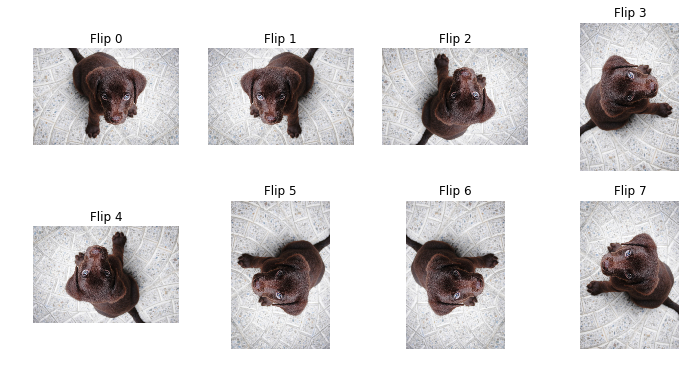

In [ ]:
dih = PILDihedral(p=1.)
dih.accept_types(PILImage)
_,axs = plt.subplots(2,4, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    dih = PILDihedral(p=1., draw=i)
    dih.accept_types(PILImage)
    show_image(dih(img, filt=0), ctx=ax, title=f'Flip {i}')

In [ ]:
t = _pnt2tensor([[1,0], [2,1]], (3,3))
x = _tensor2pil(t)
for i in range(8):
    dih = PILDihedral(p=1., draw=i)
    dih.accept_types(PILImage)
    y = dih(x, filt=0)
    res = tensor(array(y))
    dih.accept_types(TensorPoint)
    pnts = tensor([[1.,0.], [2,1]]) -1
    a,b = dih(pnts, filt=0), res.nonzero().flip(1).float() -1
    assert equals(a,b) or equals(a,b.flip(0))

## Affine and coord tfm on the GPU

In [ ]:
def _batch_ex(bs):
    timg = tensor(array(img)).permute(2,0,1).float()/255.
    return timg[None].expand(bs, *timg.shape)

In [ ]:
# export
def clip_remove_empty(bbox, label):
    "Clip bounding boxes with image border and label background the empty ones."
    bbox = torch.clamp(bbox, -1, 1)
    empty = ((bbox[...,2] - bbox[...,0])*(bbox[...,3] - bbox[...,1]) < 0.)
    if isinstance(label, torch.Tensor): label[empty] = 0
    else: label = [0 if m else l for l,m in zip(label,empty)] 
    return [bbox, label]

In [ ]:
bb = torch.tensor([[-2,-0.5,0.5,1.5], [-0.5,-0.5,0.5,0.5], [1,0.5,0.5,0.75]])
bb,lbl = clip_remove_empty(bb, ['too big', 'normal', 'empty'])
test_eq(bb, torch.tensor([[-1,-0.5,0.5,1.], [-0.5,-0.5,0.5,0.5], [1,0.5,0.5,0.75]]))
test_eq(lbl, ['too big', 'normal', 0])

In [ ]:
class AffineCoordTfm(RandTransform):
    "Combine and apply affine and coord transforms"
    order = 30
    def __init__(self, aff_fs=None, coord_fs=None, size=None, mode='bilinear', pad_mode='reflection'):
        self.aff_fs,self.coord_fs,self.mode,self.pad_mode = L(aff_fs),L(coord_fs),mode,pad_mode
        self.size = None if size is None else (size,size) if isinstance(size, int) else tuple(size)
    
    def randomize(self, b): 
        if isinstance(b, tuple): b = b[0]
        self.do,self.mat = True,self._get_affine_mat(b)[:,:2]
        for t in self.coord_fs: t.randomize(b)
        
    def compose(self, tfm):
        "Compose `self` with another `AffineCoordTfm` to only do the interpolation step once"
        self.aff_fs   += tfm.aff_fs
        self.coord_fs += tfm.coord_fs
    
    def _get_affine_mat(self, x):
        aff_m = torch.eye(3, dtype=x.dtype, device=x.device)
        aff_m = aff_m.unsqueeze(0).expand(x.size(0), 3, 3)
        ms = [f(x) for f in self.aff_fs]
        ms = [m for m in ms if m is not None]
        for m in ms: aff_m = aff_m @ m
        return aff_m
    
    def encodes(self, x:TensorImage):
        if self.mat is None and len(self.coord_tfms)==0: return x
        bs = x.size(0)
        size = tuple(x.shape[-2:]) if self.size is None else size
        size = (bs,x.size(1)) + size
        coords = F.affine_grid(self.mat, size)
        coords = compose_tfms(coords, self.coord_fs)
        return F.grid_sample(x, coords, mode=self.mode, padding_mode=self.pad_mode)
    
    def encodes(self, x:TensorMask):
        old_mode = self.mode
        res = self._get_func(self.encodes, TensorImage)(x.float()[:,None]).long()[:,0]
        self.mode = old_mode
        return res
    
    def encodes(self, x:TensorPoint):
        x = (x - self.mat[:,:,2].unsqueeze(1)) @ torch.inverse(self.mat[:,:,:2].transpose(1,2))
        return compose_tfms(x, self.coord_fs, invert=True)
    
    def encodes(self, x:TensorBBox):
        bbox,label = x
        bs,n = bbox.shape[:2]
        pnts = stack([bbox[...,:2], stack([bbox[...,0],bbox[...,3]],dim=2), 
                      stack([bbox[...,2],bbox[...,1]],dim=2), bbox[...,2:]], dim=2)
        pnts = self._get_func(self.encodes, TensorPoint)(pnts.view(bs, 4*n, 2))
        pnts = pnts.view(bs, n, 4, 2)
        tl,dr = pnts.min(dim=2)[0],pnts.max(dim=2)[0]
        return clip_remove_empty(torch.cat([tl, dr], dim=2), label)

Multipliy all the matrices returned by `aff_fs` before doing the corresponding affine transformation on a basic grid corresponding to `size`, then applies all `coord_fs` on the resulting flow of coordinates before finally doing an interpolation with `mode` and `pad_mode`.

In [ ]:
show_doc(AffineCoordTfm.compose)

<h4 id="<code>AffineCoordTfm.compose</code>" class="doc_header"><code>AffineCoordTfm.compose</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>AffineCoordTfm.compose</code>(**`tfm`**)

Compose `self` with another `AffineCoordTfm` to only do the interpolation step once

In [ ]:
def affine_mat(*ms):
    "Restructure length-6 vector `ms` into an affine matrix with 0,0,1 in the last line"
    return stack([stack([ms[0], ms[1], ms[2]], dim=1),
                  stack([ms[3], ms[4], ms[5]], dim=1),
                  stack([t0(ms[0]), t0(ms[0]), t1(ms[0])], dim=1)], dim=1)

In [ ]:
# export
def mask_tensor(x, p=0.5, neutral=0.):
    if p==1.: return x
    if neutral != 0: x.add_(-neutral)
    mask = x.new_empty(*x.size()).bernoulli_(p)
    x.mul_(mask)
    return x.add_(neutral) if neutral != 0 else x

In [ ]:
def flip_mat(x, p=0.5):
    "Return a random flip matrix"
    mask = mask_tensor(-x.new_ones(x.size(0)), p=p, neutral=1.)
    return affine_mat(mask,     t0(mask), t0(mask),
                      t0(mask), t1(mask), t0(mask))

In [ ]:
x = flip_mat(torch.randn(100,4,3))
test_eq(set(x[:,0,0].numpy()), {-1,1}) #might fail with probability 2*2**(-100) (picked only 1s or -1s)

In [ ]:
def Flip(p=0.5, size=None, mode='bilinear', pad_mode='reflection'): 
    "Randomly flip a batch of images with a probabilit `p`"
    return AffineCoordTfm(aff_fs=partial(flip_mat, p=p), size=size, mode=mode, pad_mode=pad_mode)

In [ ]:
flip = Flip(p=1.)
flip.accept_types(TensorImage)
t = _pnt2tensor([[1,0], [2,1]], (3,3))
y = flip(t[None,None], filt=0)
test_eq(y, _pnt2tensor([[1,0], [0,1]], (3,3))[None,None])

flip.accept_types(TensorPoint)
pnts = tensor([[1.,0.], [2,1]]) -1
test_eq(flip(pnts[None], filt=0), tensor([[[1.,0.], [0,1]]]) -1)

flip.accept_types(TensorBBox)
pnts = tensor([[1.,0., 2.,1]]) -1
flip((pnts[None], ["nothing"]), filt=0)[0]
test_eq(flip((pnts[None], ["nothing"]), filt=0)[0], tensor([[[0.,0., 1.,1.]]]) -1)

In [ ]:
def _draw_mask(x, def_draw, draw=None, p=0.5, neutral=0.):
    if draw is None: draw=def_draw
    if isinstance(draw, Callable):
        res = x.new_empty(x.size(0))
        for i in range_of(res): res[i] = draw()
    elif is_listy(draw):
        test_eq(len(draw), x.size(0))
        res = tensor(draw, dtype=x.dtype, device=x.device)
    else: res = x.new_zeros(x.size(0)) + draw
    return mask_tensor(res, p=p, neutral=neutral)

In [ ]:
x = torch.zeros(5,2,3)
def_draw = lambda: random.randint(0,7)
t = _draw_mask(x, def_draw)
assert (0. <= t).all() and (t <= 7).all() 
t = _draw_mask(x, def_draw, 1)
assert (0. <= t).all() and (t <= 1).all() 
test_eq(_draw_mask(x, def_draw, 1, p=1), tensor([1.,1,1,1,1]))
test_eq(_draw_mask(x, def_draw, [0,1,2,3,4], p=1), tensor([0.,1,2,3,4]))

In [ ]:
def dihedral_mat(x, p=0.5, draw=None):
    "Return a random dihedral matrix"
    def _def_draw(): return random.randint(0,7)
    idx = _draw_mask(x, _def_draw, draw=draw, p=p).long()
    xs = tensor([1,-1,1,-1,-1,1,1,-1])[idx]
    ys = tensor([1,1,-1,1,-1,-1,1,-1])[idx]
    m0 = tensor([1,1,1,0,1,0,0,0])[idx]
    m1 = tensor([0,0,0,1,0,1,1,1])[idx]
    return affine_mat(xs*m0,  xs*m1,  t0(xs),
                      ys*m1,  ys*m0,  t0(xs)).float()
    mask = mask_tensor(-x.new_ones(x.size(0)), p=p, neutral=1.)

In [ ]:
def Dihedral(p=0.5, draw=None, size=None, mode='bilinear', pad_mode='reflection'): 
    "Apply a random dihedral transformation to a batch of images with a probability `p`"
    return AffineCoordTfm(aff_fs=partial(dihedral_mat, p=p, draw=draw), size=size, mode=mode, pad_mode=pad_mode)

`draw` can be specified if you want to customize which flip is picked when the transform is applied (default is a random number between 0 and 7). It can be an integer between 0 and 7, a list of such integers (which then should have a length equal to the size of the batch) or a callable that returns an integer between 0 and 7.

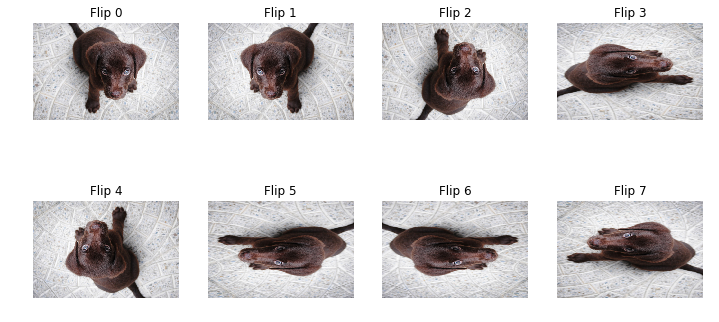

In [ ]:
t = _batch_ex(8)
dih = Dihedral(p=1., draw=list(range(8)))
dih.accept_types(TensorImage)
y = dih(t, filt=0)
_,axs = plt.subplots(2,4, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'Flip {i}')

In [ ]:
#Test behavior with iamges and points is consistent
t = _pnt2tensor([[1,0], [2,1], [2,2]], (3,3))[None,None].expand(8,1,3,3)
dih = Dihedral(p=1., draw=list(range(8)))
dih.accept_types(TensorImage)
y = dih(t, filt=0)
res = y.nonzero()
dih.accept_types(TensorPoint)
pnts = tensor([[[1.,0.], [2,1], [2,2]]]) -1
z = dih(pnts.expand(8,3,2), filt=0)+1
for i in range(8):
    vals = {(t[0] + t[1]*3).item() for t in res[i*3:(i+1)*3][:,2:].flip(1)}
    vals1 = {(t[0] + t[1]*3).item() for t in z[i]}
    test_eq(vals, vals1)
    
#Test order is the same as PILDihedral
tt = _pnt2tensor([[1,0], [2,1], [2,2]], (3,3))
x = _tensor2pil(tt)
for i in range(8):
    dih1 = PILDihedral(p=1., draw=i)
    dih1.accept_types(PILImage)
    y1 = dih1(x, filt=0)
    test_eq(y[i,0], tensor(array(y1)))

In [ ]:
# export
def rotate_mat(x, max_deg=10, p=0.5, draw=None):
    def _def_draw(): return random.uniform(-max_deg,max_deg)
    thetas = _draw_mask(x, _def_draw, draw=draw, p=p) * math.pi/180
    return affine_mat(thetas.cos(), thetas.sin(), t0(thetas),
                     -thetas.sin(), thetas.cos(), t0(thetas))

In [ ]:
def Rotate(max_deg=10, p=0.5, draw=None, size=None, mode='bilinear', pad_mode='reflection'):
    "Apply a random rotation of at most `max_deg` with probability `p` to a batch of images"
    return AffineCoordTfm(partial(rotate_mat, max_deg=max_deg, p=p, draw=draw), 
                          size=size, mode=mode, pad_mode=pad_mode)

`draw` can be specified if you want to customize which angle is picked when the transform is applied (default is a random flaot between `-max_deg` and `max_deg`). It can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

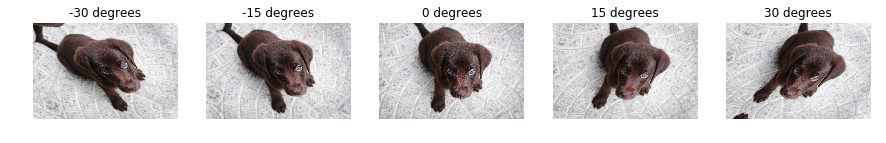

In [ ]:
thetas = [-30,-15,0,15,30]
rot = Rotate(draw=thetas, p=1.)
rot.accept_types(TensorImage)
y = rot(_batch_ex(5), filt=0)
_,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'{thetas[i]} degrees')

In [ ]:
# export
def zoom_mat(x, max_zoom=1.1, p=0.5, draw=None, draw_x=None, draw_y=None):
    def _def_draw():     return random.uniform(1., max_zoom)
    def _def_draw_ctr(): return random.uniform(0.,1.)
    s = 1/_draw_mask(x, _def_draw, draw=draw, p=p, neutral=1.)
    col_pct = _draw_mask(x, _def_draw_ctr, draw=draw_x, p=1.)
    row_pct = _draw_mask(x, _def_draw_ctr, draw=draw_y, p=1.)
    col_c = (1-s) * (2*col_pct - 1)
    row_c = (1-s) * (2*row_pct - 1)
    return affine_mat(s,     t0(s), col_c,
                      t0(s), s,     row_c)

In [ ]:
def Zoom(max_zoom=1.1, p=0.5, draw=None, draw_x=None, draw_y=None, size=None, mode='bilinear', pad_mode='reflection'):
    "Apply a random zoom of at most `max_zoom` with probability `p` to a batch of images"
    return AffineCoordTfm(partial(zoom_mat, max_zoom=max_zoom, p=p, draw=draw, draw_x=draw_x, draw_y=draw_y), 
                          size=size, mode=mode, pad_mode=pad_mode)

`draw`, `draw_x` and `draw_y` can be specified if you want to customize which scale and center are picked when the transform is applied (default is a random float between 1 and `max_zoom` for the first, between 0 and 1 for the last two). Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callbale that returns a float.

`draw_x` and `draw_y` are expected to be the position of the center in pct, 0 meaning the most left/top possible and 1 meaning the most right/bottom possible.

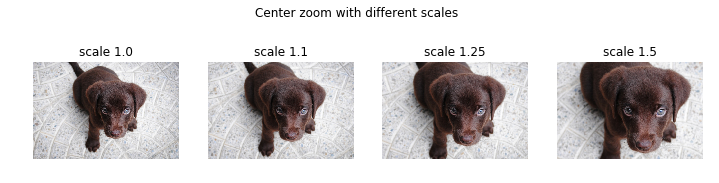

In [ ]:
scales = [1., 1.1, 1.25, 1.5]
zoom = Zoom(draw=scales, p=1., draw_x=0.5, draw_y=0.5)
zoom .accept_types(TensorImage)
y = zoom(_batch_ex(4), filt=0)
fig,axs = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Center zoom with different scales')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

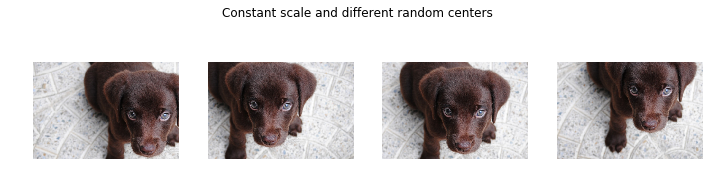

In [ ]:
zoom = Zoom(draw=1.5, p=1.)
zoom .accept_types(TensorImage)
y = zoom(_batch_ex(4), filt=0)
fig,axs = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Constant scale and different random centers')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax)

### Warping

In [ ]:
# export
def find_coeffs(p1, p2):
    m = []
    p = p1[:,0,0]
    #The equations we'll need to solve.
    for i in range(p1.shape[1]):
        m.append(stack([p2[:,i,0], p2[:,i,1], t1(p), t0(p), t0(p), t0(p), -p1[:,i,0]*p2[:,i,0], -p1[:,i,0]*p2[:,i,1]]))
        m.append(stack([t0(p), t0(p), t0(p), p2[:,i,0], p2[:,i,1], t1(p), -p1[:,i,1]*p2[:,i,0], -p1[:,i,1]*p2[:,i,1]]))
    #The 8 scalars we seek are solution of AX = B
    A = stack(m).permute(2, 0, 1)
    B = p1.view(p1.shape[0], 8, 1)
    return torch.solve(B,A)[0]

In [ ]:
# export
def apply_perspective(coords, coeffs):
    sz = coords.shape
    coords = coords.view(sz[0], -1, 2)
    coeffs = torch.cat([coeffs, t1(coeffs[:,:1])], dim=1).view(coeffs.shape[0], 3,3)
    coords = coords @ coeffs[...,:2].transpose(1,2) + coeffs[...,2].unsqueeze(1)
    coords.div_(coords[...,2].unsqueeze(-1))
    return coords[...,:2].view(*sz)

In [ ]:
# export
class _WarpCoord():
    def __init__(self, magnitude=0.2, p=0.5, draw_x=None, draw_y=None):
        self.coeffs,self.magnitude,self.p,self.draw_x,self.draw_y = None,magnitude,p,draw_x,draw_y
    
    def _def_draw(self): return random.uniform(-self.magnitude, self.magnitude)
    def randomize(self, x):
        up_t = _draw_mask(x, self._def_draw, self.draw_x, p=self.p)
        lr_t = _draw_mask(x, self._def_draw, self.draw_y, p=self.p)
        orig_pts = torch.tensor([[-1,-1], [-1,1], [1,-1], [1,1]], dtype=x.dtype, device=x.device)
        self.orig_pts = orig_pts.unsqueeze(0).expand(x.size(0),4,2)
        targ_pts = stack([stack([-1-up_t, -1-lr_t]), stack([-1+up_t, 1+lr_t]), 
                          stack([ 1+up_t, -1+lr_t]), stack([ 1-up_t, 1-lr_t])])
        self.targ_pts = targ_pts.permute(2,0,1)
    
    def __call__(self, x, invert=False): 
        coeffs = find_coeffs(self.targ_pts, self.orig_pts) if invert else find_coeffs(self.orig_pts, self.targ_pts)
        return apply_perspective(x, coeffs)

In [ ]:
def Warp(magnitude=0.2, p=0.5, draw_x=None, draw_y=None,size=None, mode='bilinear', pad_mode='reflection'):
    return AffineCoordTfm(coord_fs=_WarpCoord(magnitude=magnitude, p=p, draw_x=draw_x, draw_y=draw_y),
                          size=size, mode=mode, pad_mode=pad_mode)

`draw_x` and `draw_y` can be specified if you want to customize the magnitudes that are picked when the transform is applied (default is a random float between `-magnitude` and `magnitude`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

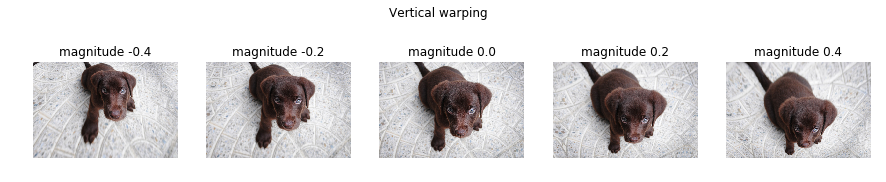

In [ ]:
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_ud=scales, draw_lr=0.)
warp.accept_types(TensorImage)
y = warp(_batch_ex(5), filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Vertical warping')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'magnitude {scales[i]}')

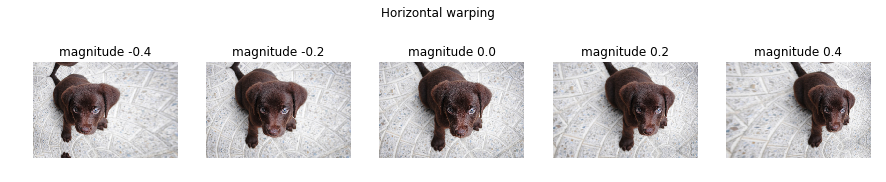

In [ ]:
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_lr=scales, draw_ud=0.)
warp.accept_types(TensorImage)
y = warp(_batch_ex(5), filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Horizontal warping')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'magnitude {scales[i]}')

In [ ]:
#hide
x1 = tensor([[1.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]])
x2 = tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,1.]])
x3 = tensor([[1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.]])
x4 = tensor([[0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.]])
warp = Warp(p=1., draw_lr=[0.,0,-0.5,0.5], draw_ud=[-0.5,0.5,0.,0.])
warp.accept_types(TensorImage)
y = warp(stack([x1,x2,x3,x4])[:,None], filt=0)
test_eq(y[0,0], tensor([[0.,1.,0.,1.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]]))
test_eq(y[1,0], tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,1.,0.,1.,0.]]))
test_eq(y[2,0], tensor([[0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]]))
test_eq(y[3,0], tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.]]))

In [ ]:
#hide
warp.accept_types(TensorPoint)
x = torch.tensor([[[-1.,-1], [1,-1]], [[-1,1],[1,1]], [[-1,-1], [-1,1]], [[1,-1], [1,1]]])
y = warp(x, filt=0)
test_eq(y, torch.tensor([[[-0.5,-1], [0.5,-1]], [[-0.5,1],[0.5,1]], [[-1,-0.5], [-1,0.5]], [[1,-0.5], [1,0.5]]]))

## Ligthing transforms

In [ ]:
# export
def logit(x):
    "Logit of `x`, clamped to avoid inf."
    x = x.clamp(1e-7, 1-1e-7)
    return -(1/x-1).log()

In [ ]:
# export
class LightingTransform(RandTransform):
    "Applied `fs` to the logits"
    order = 15
    def __init__(self, fs): self.fs=L(fs)
    def randomize(self, b):
        self.do = True
        if isinstance(b, tuple): b = b[0]
        for t in self.fs: t.randomize(b)
    
    def compose(self, tfm): 
        "Compose `self` with another `LightingTransform`"
        self.fs += tfm.fs
    
    def encodes(self,x:TensorImage): return torch.sigmoid(compose_tfms(logit(x), self.fs))
    def encodes(self,x:TensorMask):  return x

In [ ]:
# export
class _BrightnessLogit():
    def __init__(self, max_lighting=0.2, p=0.75, draw=None): 
        self.max_lighting,self.p,self.draw = max_lighting,p,draw
    
    def _def_draw(self): return random.uniform(0.5*(1-self.max_lighting), 0.5*(1+self.max_lighting))
    
    def randomize(self, x):
        self.change = _draw_mask(x, self._def_draw, draw=self.draw, p=self.p)
        
    def __call__(self, x): return x.add_(logit(self.change[:,None,None,None]))

In [ ]:
def Brightness(max_lighting=0.2, p=0.75, draw=None):
    "Apply change in brightness of `max_lighting` to batch of images with probability `p`."
    return LightingTransform(_BrightnessLogit(max_lighting, p, draw))

`draw` can be specified if you want to customize the magnitude that is picked when the transform is applied (default is a random float between `-0.5*(1-max_lighting)` and `0.5*(1+max_lighting)`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

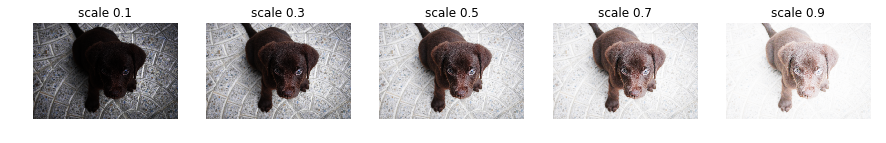

In [ ]:
scales = [0.1, 0.3, 0.5, 0.7, 0.9]
bright = Brightness(p=1., draw=scales)
bright .accept_types(TensorImage)
y = bright(_batch_ex(5), filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [ ]:
# export
class _ContrastLogit():
    def __init__(self, max_lighting=0.2, p=0.75, draw=None): 
        self.max_lighting,self.p,self.draw = max_lighting,p,draw
    
    def _def_draw(self): 
        return math.exp(random.uniform(math.log(1-self.max_lighting), -math.log(1-self.max_lighting)))
    
    def randomize(self, x):
        self.change = _draw_mask(x, self._def_draw, draw=self.draw, p=self.p)
        
    def __call__(self, x): return x.mul_(self.change[:,None,None,None])

In [ ]:
def Contrast(max_lighting=0.2, p=0.75, draw=None):
    "Apply change in brightness of `max_lighting` to batch of images with probability `p`."
    return LightingTransform(_ContrastLogit(max_lighting, p, draw))

`draw` can be specified if you want to customize the magnitude that is picked when the transform is applied (default is a random float taken with the log uniform distribution between `(1-max_lighting)` and `1/(1-max_lighting)`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

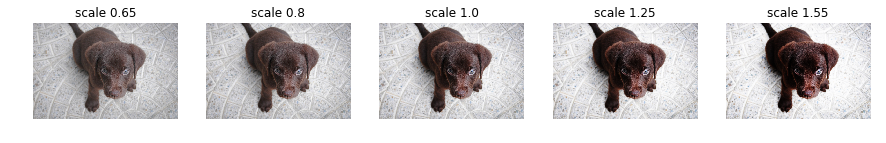

In [ ]:
scales = [0.65, 0.8, 1., 1.25, 1.55]
cont = Contrast(p=1., draw=scales)
cont .accept_types(TensorImage)
y = cont(_batch_ex(5), filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [ ]:
x,y = pnt_dsrc[0]
x = tensor(array(x)).float()/255
x = x[None,None].expand(5,1,35,28)
y = y[None].expand(5,5,2)
b = x,y

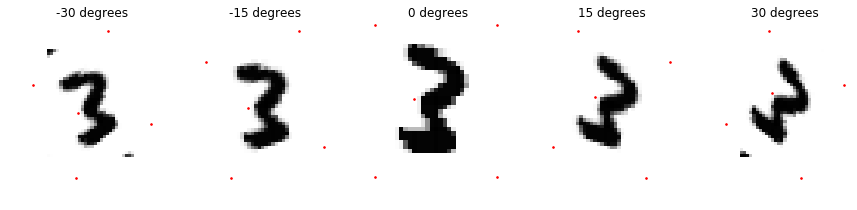

In [ ]:
thetas = [-30,-15,0,15,30]
rot = Rotate(draw=thetas, p=1.)
rot.accept_types([TensorImage, TensorPoint])
xb,yb = rot(b, filt=0)
_,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    pnt_dsrc.show((xb[i], yb[i]), ctx=ax)
    ax.set_title(f'{thetas[i]} degrees')

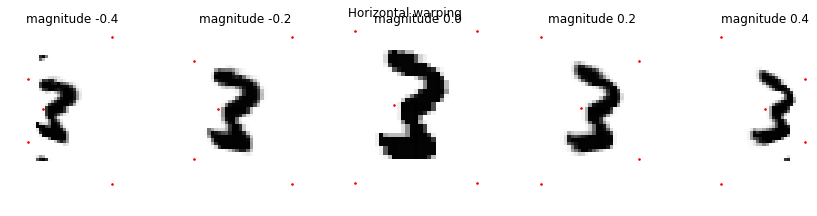

In [ ]:
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_lr=scales, draw_ud=0.)
warp.accept_types([TensorImage, TensorPoint])
xb,yb = warp(b, filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Horizontal warping')
for i,ax in enumerate(axs.flatten()):
    pnt_dsrc.show((xb[i], yb[i]), ctx=ax)
    ax.set_title(f'magnitude {scales[i]}')

In [ ]:
x,y = coco_dsrc[0]
x = tensor(array(x)).permute(2,0,1).float()/255
x = x[None].expand(5,3,128,128)
y = (y[0][None].expand(5,3,4), y[1][None].expand(5,3))
b = x,y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


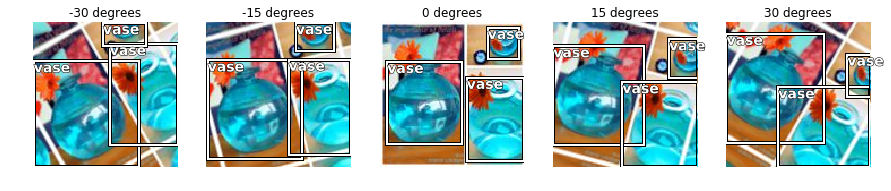

In [ ]:
thetas = [-30,-15,0,15,30]
rot = Rotate(draw=thetas, p=1.)
rot.accept_types([TensorImage, TensorBBox])
xb,yb = rot(b, filt=0)
_,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    coco_dsrc.show((xb[i], (yb[0][i], yb[1][i])), ctx=ax)
    ax.set_title(f'{thetas[i]} degrees')

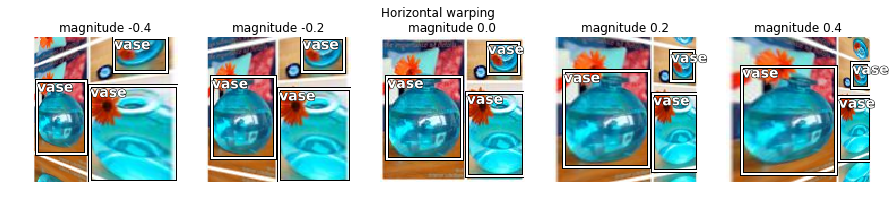

In [ ]:
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_lr=scales, draw_ud=0.)
warp.accept_types([TensorImage, TensorBBox])
xb,yb = warp(b, filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Horizontal warping')
for i,ax in enumerate(axs.flatten()):
    coco_dsrc.show((xb[i], (yb[0][i], yb[1][i])), ctx=ax)
    ax.set_title(f'magnitude {scales[i]}')

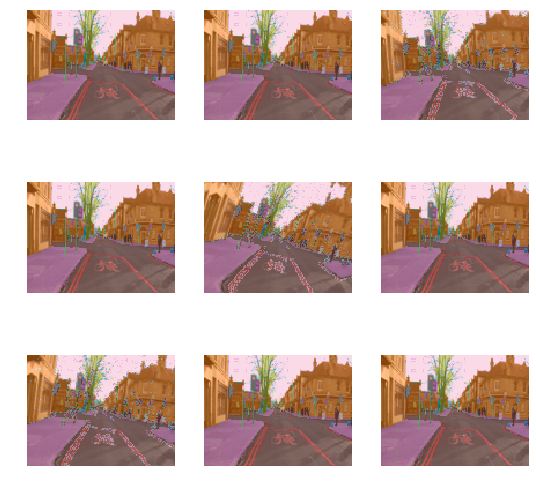

In [ ]:
cam_dsrc = DataSource([cam_fn]*10, [Imagify(), [_cam_lbl, Maskify()]], tuple_tfms=[ImageToByteTensor()])
cam_tdl = TfmdDL(cam_dsrc.train, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(partial(rotate, max_deg=30))], bs=9)
_,axs = plt.subplots(3,3, figsize=(9,9))
cam_tdl.show_batch(ctxs=axs.flatten())

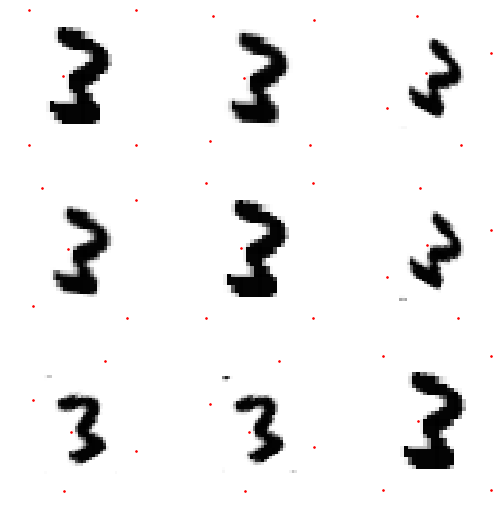

In [ ]:
pnt_dsrc = DataSource([mnist_fn]*10, [Imagify(_pnt_open), [_pnt_lbl,Pointify()]], 
                 tuple_tfms=[PointScaler(), ImageToByteTensor()])
pnt_tdl = TfmdDL(pnt_dsrc.train, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(partial(rotate, max_deg=30))], bs=9)
_,axs = plt.subplots(3,3, figsize=(9,9))
pnt_tdl.show_batch(ctxs=axs.flatten())

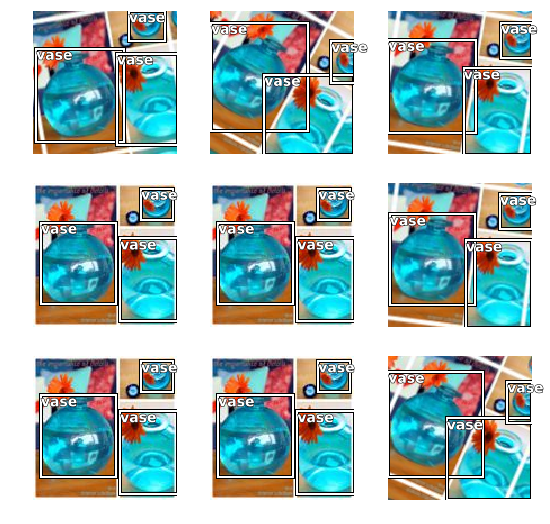

In [ ]:
coco_dsrc = DataSource([coco_fn]*10, [Imagify(), [_coco_lbl, BBoxify(), BBoxCategorize()]], 
                  tuple_tfms=[BBoxScaler(), ImageToByteTensor()])
coco_tdl = TfmdDL(coco_dsrc.train, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(partial(rotate, max_deg=30))], bs=9)
_,axs = plt.subplots(3,3, figsize=(9,9))
coco_tdl.show_batch(ctxs=axs.flatten())

### Warping

In [ ]:
# export
def find_coeffs(p1, p2):
    matrix = []
    p = p1[:,0,0]
    #The equations we'll need to solve.
    for i in range(p1.shape[1]):
        matrix.append(stack([p2[:,i,0], p2[:,i,1], t1(p), t0(p), t0(p), t0(p), -p1[:,i,0]*p2[:,i,0], -p1[:,i,0]*p2[:,i,1]]))
        matrix.append(stack([t0(p), t0(p), t0(p), p2[:,i,0], p2[:,i,1], t1(p), -p1[:,i,1]*p2[:,i,0], -p1[:,i,1]*p2[:,i,1]]))
    #The 8 scalars we seek are solution of AX = B
    A = stack(matrix).permute(2, 0, 1)
    B = p1.view(p1.shape[0], 8, 1)
    return torch.solve(B,A)[0]

In [ ]:
# export
def apply_perspective(coords, coeffs):
    sz = coords.shape
    coords = coords.view(sz[0], -1, 2)
    coeffs = torch.cat([coeffs, t1(coeffs[:,:1])], dim=1).view(coeffs.shape[0], 3,3)
    coords = coords @ coeffs[...,:2].transpose(1,2) + coeffs[...,2].unsqueeze(1)
    coords.div_(coords[...,2].unsqueeze(-1))
    return coords[...,:2].view(*sz)

In [ ]:
# export
class Warp():
    def __init__(self, magnitude=0.2, p=0.5):
        self.coeffs,self.magnitude,self.p = None,magnitude,p
    
    def randomize(self, x):
        up_t = masked_uniform(x, -self.magnitude, self.magnitude, x.size(0), p=self.p)
        lr_t = masked_uniform(x, -self.magnitude, self.magnitude, x.size(0), p=self.p)
        orig_pts = torch.tensor([[-1,-1], [-1,1], [1,-1], [1,1]], dtype=x.dtype, device=x.device)
        self.orig_pts = orig_pts.unsqueeze(0).expand(x.size(0),4,2)
        targ_pts = stack([stack([-1-up_t, -1-lr_t]), stack([-1+up_t, 1+lr_t]), 
                          stack([ 1+up_t, -1+lr_t]), stack([ 1-up_t, 1-lr_t])])
        self.targ_pts = targ_pts.permute(2,0,1)
    
    def __call__(self, x, invert=False): 
        coeffs = find_coeffs(self.targ_pts, self.orig_pts) if invert else find_coeffs(self.orig_pts, self.targ_pts)
        return apply_perspective(x, coeffs)

In [ ]:
tds = TfmdDS([fn]*10, [[Imagify()], [_lbl,Pointify()]], tuple_tfms=[PointScaler(), ImageToByteTensor()])
tdl = TfmdDL(tds, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(coord_tfms=Warp(0.4))], bs=9)

In [ ]:
tds = TfmdDS([fn]*10, [[Imagify()], [_lbl1,BBoxify(), tcat]], tuple_tfms=[BBoxScaler(), ImageToByteTensor()])
tdl = TfmdDL(tds, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(coord_tfms=Warp())], bs=9)

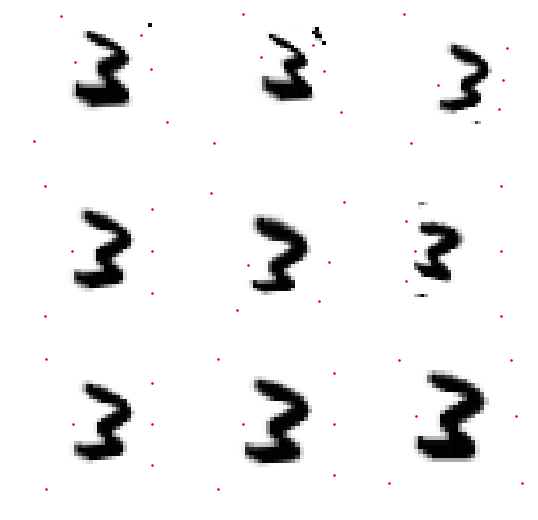

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
tdl.show_batch(ctxs=axs.flatten())

In [ ]:
PILImage.kwargs['cmap'] = 'Greys'

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
fns = get_image_files(mnist)
mnist_fn = fns[0]

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
fns = get_image_files(camvid)
cam_fn = fns[0]
def _cam_lbl(x): return camvid/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'
cam_dsrc = DataSource([cam_fn]*10, [Imagify(), [_cam_lbl, Maskify()]])

In [ ]:
def _pnt_open(fn): return Image.open(fn).resize((28,35))
def _pnt_lbl(x): return np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
pnt_dsrc = DataSource([mnist_fn]*10, [Imagify(_pnt_open), [_pnt_lbl,Pointify()]], 
                      tuple_tfms=PointScaler())

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]
def _coco_lbl(x): return bbox
coco_dsrc = DataSource([coco_fn]*10, [Imagify(), [_coco_lbl, BBoxify(), BBoxCategorize()]], 
                  tuple_tfms=BBoxScaler())